In [1]:
import datetime
import logging
import os

from matplotlib import pyplot as plt

from ocean_navigation_simulator.environment.ArenaFactory import ArenaFactory
from ocean_navigation_simulator.environment.PlatformState import (
    SpatioTemporalPoint,
)
from ocean_navigation_simulator.problem_factories.Constructor import Constructor
from ocean_navigation_simulator.utils.misc import set_arena_loggers

set_arena_loggers(logging.DEBUG)

# Set-Up for Simulation

## Platform Speed, Forecasted and true currents

In [3]:
# Forecast System that we can use:
# - HYCOM Global (daily forecasts, xh resolution, 1/12 deg spatial resolution)
# - Copernicus Global (daily forecasts for 5 days out, xh resolution, 1/12 deg spatial resolution)
# - NOAA West Coast Nowcast System (daily nowcasts for 24h, xh resolution, 10km spatial resolution)
# Note: if you switch it, you need to delete the old FC files, otherwise the system will use those. It just grabs all the files in the folder 'folder_for_forecast_files'

max_speed_of_platform_in_meter_per_second = 0.2
forecast_system_to_use = "noaa"  # either of ['HYCOM', 'Copernicus', 'noaa']

folder_for_forecast_files = "/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/jupyter_FC_data/noaa_forecast_files/"
if not os.path.exists(folder_for_forecast_files):
        os.makedirs(folder_for_forecast_files)

# Currently true currents are set to Copernicus
true_ocean_current_dict = {
            "field": "OceanCurrents",
            "source": "opendap",
            "source_settings": {
                "service": "copernicus",
                "currents": "total",
                "USERNAME": "mmariuswiggert",
                "PASSWORD": "tamku3-qetroR-guwneq",
                "DATASET_ID": "cmems_mod_glo_phy_anfc_merged-uv_PT1H-i",
            }}

# Configs for simulator
simulation_timeout = 3600*24 *5  # 5 days

arena_config = {
    "casadi_cache_dict": {
        "deg_around_x_t": 0.3,
        "time_around_x_t": 86400.0,
    },  # This is 24h in seconds!
    "platform_dict": {
        "battery_cap_in_wh": 400.0,
        "u_max_in_mps": max_speed_of_platform_in_meter_per_second,
        "motor_efficiency": 1.0,
        "solar_panel_size": 1.0,
        "solar_efficiency": 0.2,
        "drag_factor": 675.0,
        "dt_in_s": 600.0,
    },
    "use_geographic_coordinate_system": True,
    "spatial_boundary": None,
    "ocean_dict": {
        "region": "Region 1",  # This is the region of northern California
        "hindcast": true_ocean_current_dict,
        "forecast": #true_ocean_current_dict,
            {
            "field": "OceanCurrents",
            "source": "forecast_files",
            "source_settings": {"source": forecast_system_to_use,
                                "folder": folder_for_forecast_files,
                                "type": "forecast"},
        },
    },
    "solar_dict": {"hindcast": None, "forecast": None},
    "seaweed_dict": {"hindcast": None, "forecast": None},
    "bathymetry_dict" : {
        "field": "Bathymetry",
        "source": "gebco",
        "source_settings": {
            "filepath": "bathymetry_global_res_0.083_0.083_max.nc"
        },
        "distance": {
            "filepath": "bathymetry_distance_res_0.004_max_elevation_0_northern_california.nc",
            "safe_distance": 0.01,
        },
        "casadi_cache_settings": {"deg_around_x_t": 20},
        "use_geographic_coordinate_system": True,
    }
}

objectiveConfig = {"type": "nav"}

## Controller Settings

In [4]:
t_max_planning_ahead_in_seconds = 3600*60 # that is 60h

ctrl_config={  'T_goal_in_seconds': t_max_planning_ahead_in_seconds,
              'accuracy': 'high',
              'artificial_dissipation_scheme': 'local_local',
              'ctrl_name': 'ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner',
              'deg_around_xt_xT_box': 0.3,
              'direction': 'multi-time-reach-back',
              'grid_res': 0.005,
              'n_time_vector': 100,
              'obstacle_dict': {'obstacle_value': 1,
                                'obstacle_file': 'bathymetry_distance_res_0.004_max_elevation_0_northern_california.nc',
                                'safe_distance_to_obstacle': 0},
              'progress_bar': True,
              'replan_every_X_seconds': None,
              'replan_on_new_fmrc': True,
              'calc_opt_traj_after_planning': True,
              'use_geographic_coordinate_system': True}

## Mission Setting (Start -> Target Region)

In [5]:
print("current UTC datetime is: ", datetime.datetime.now())

start_time = "2023-05-25T19:00:00+00:00"  # in UTC
OB_point = {"lat": 37.738160, "lon": -122.545469}
HMB_point = {"lat": 37.482812, "lon": -122.531450}

x_0_dict = {"date_time": start_time}
x_0_dict.update(HMB_point)

missionConfig = {
    "target_radius": 0.02,  # in degrees
    "x_0": [x_0_dict],  # the start position and time
    "x_T": OB_point,  # the target position
}

current UTC datetime is:  2023-05-25 14:53:31.067892


## Downloading Forecast Files (does not need to be re-run)

In [12]:
# Note: This needs to be run only once, not when re-running constructor etc.
point_to_check = SpatioTemporalPoint.from_dict(missionConfig['x_0'][0])
t_interval = [point_to_check.date_time - datetime.timedelta(hours=35),
              point_to_check.date_time + datetime.timedelta(
                  seconds=simulation_timeout
                          + arena_config['casadi_cache_dict'][
                      'time_around_x_t'] + 7200)]

# Note: it connects to C3 and downloads the relevant forecast files to the local repo
ArenaFactory.download_required_files(
        archive_source = arena_config['ocean_dict']['forecast']['source_settings']['source'],
        archive_type = arena_config['ocean_dict']['forecast']['source_settings']['type'],
        download_folder=arena_config['ocean_dict']['forecast']['source_settings']['folder'],
        t_interval = t_interval,
        region= arena_config['ocean_dict']['region'],
        points= [point_to_check])

Starting to connect to c3


Only 2/8 files in the database for noaa, forecast, Region 1 and t_0=2023-05-24 08:00:00+00:00 and t_T=2023-05-31 21:00:00+00:00: 
- nos.wcofs.regulargrid.f003-f072.20230524.t03z.nc
- nos.wcofs.regulargrid.f003-f072.20230525.t03z.nc
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:02<00:00, 31.18s/it]


['/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/jupyter_FC_data/noaa_forecast_files/nos.wcofs.regulargrid.f003-f072.20230524.t03z.nc',
 '/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/jupyter_FC_data/noaa_forecast_files/nos.wcofs.regulargrid.f003-f072.20230525.t03z.nc']

## Create Arena, Problem, Controller

In [6]:
# Step 0: Create Constructor object which contains arena, problem, controller
constructor = Constructor(
    arena_conf=arena_config,
    mission_conf=missionConfig,
    objective_conf=objectiveConfig,
    ctrl_conf=ctrl_config,
    observer_conf={"observer": None},
    timeout_in_sec=simulation_timeout,
    throw_exceptions=False,
)

In [14]:
# Step 1.1 Retrieve problem
problem = constructor.problem

# Step 1.2: Retrieve arena
arena = constructor.arena
observation = arena.reset(platform_state=problem.start_state)
problem_status = arena.problem_status(problem=problem)

# Step 2: Retrieve Controller
controller = constructor.controller

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.


# Visualize the forecasted currents

In [15]:
# Note: it will visualize the forecast that is most recent at t_start
t_start = problem.start_state.date_time
duration_of_viz = datetime.timedelta(hours=60)

abs_path = "/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/OceanPlatformControl/generated_media/"
filename = "most_current_forecast_viz_jupyter.mp4"
# TODO: make it work to directly viz in Jupyter
# from IPython.display import HTML
# HTML(filename=abs_path + path)

v_max = 0.5
x_interval=[-123, -122]
y_interval=[37, 38]
spatial_resolution=1 / 30
temporal_resolution=3600

def add_prob(ax, time):
    problem.plot(ax=ax)

arena.ocean_field.forecast_data_source.animate_data(
    output=abs_path + filename,
    x_interval=x_interval,
    y_interval=y_interval,
    spatial_resolution=spatial_resolution,
    temporal_resolution=temporal_resolution,
    t_interval=[t_start, t_start + duration_of_viz],
    vmax=v_max, vmin=0.0,
    add_ax_func=add_prob,
)

The requested final time is not part of the subset (requested: [2023-05-25 19:00:00+00:00, 2023-05-28 07:00:00+00:00]). (files: x_range: [-145.38, -112.1], y_range: [18.42, 55.78], t_range:['2023-05-25 06-00-00', '2023-05-28 03-00-00'])


In [17]:
# For a list of all FC files that are downloaded in the folder:
arena.ocean_field.forecast_data_source.files_dicts

[{'t_range': [datetime.datetime(2023, 5, 24, 6, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2023, 5, 27, 3, 0, tzinfo=datetime.timezone.utc)],
  'y_range': [18.42, 55.78],
  'x_range': [-145.38, -112.1],
  'file': '/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/jupyter_FC_data/noaa_forecast_files/nos.wcofs.regulargrid.f003-f072.20230524.t03z.nc'},
 {'t_range': [datetime.datetime(2023, 5, 25, 6, 0, tzinfo=datetime.timezone.utc),
   datetime.datetime(2023, 5, 28, 3, 0, tzinfo=datetime.timezone.utc)],
  'y_range': [18.42, 55.78],
  'x_range': [-145.38, -112.1],
  'file': '/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/jupyter_FC_data/noaa_forecast_files/nos.wcofs.regulargrid.f003-f072.20230525.t03z.nc'}]

# Visualize how far can we get in what time if the FC is accurate

In [21]:
t_max_planning_ahead_in_seconds = 3600*60 # that is 60h
radius_around_x_0 = 0.01

fwd_ctrl_config={  'T_goal_in_seconds': t_max_planning_ahead_in_seconds,
              'accuracy': 'high',
              'artificial_dissipation_scheme': 'local_local',
              'ctrl_name': 'ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner',
              'deg_around_xt_xT_box': 0.3,
              'direction': 'forward',
              'grid_res': 0.005,
              'n_time_vector': 100,
               "initial_set_radii": [radius_around_x_0, radius_around_x_0],
              'obstacle_dict': {'obstacle_value': 1,
                                'obstacle_file': 'bathymetry_distance_res_0.004_max_elevation_0_northern_california.nc',
                                'safe_distance_to_obstacle': 0},
              'progress_bar': True,
              'replan_every_X_seconds': None,
              'replan_on_new_fmrc': True,
              'calc_opt_traj_after_planning': True,
              'use_geographic_coordinate_system': True}

In [22]:
# Step 0: Create Constructor object which contains arena, problem, controller
constructor = Constructor(
    arena_conf=arena_config,
    mission_conf=missionConfig,
    objective_conf=objectiveConfig,
    ctrl_conf=fwd_ctrl_config,
    observer_conf={"observer": None},
    timeout_in_sec=simulation_timeout,
    throw_exceptions=False,
)

# Step 2: Retrieve Controller
fwd_controller = constructor.controller
fwd_controller.get_action(observation=observation)
# Note: this will currently lead to an error, that's ok (it's something in trajectory generation)

The requested final time is not part of the subset (requested: [2023-05-25 19:00:00+00:00, 2023-05-28 07:00:00+00:00]). (files: x_range: [-145.38, -112.1], y_range: [18.42, 55.78], t_range:['2023-05-25 06-00-00', '2023-05-28 03-00-00'])
Loaded forecast data does not contain the full time-horizon from x_t 2023-05-25 19:00:00+00:00 to T_goal_in_seconds 216000. Automatically adjusting to maximum available time in this forecast.
 55%|###########################################################################9                                                              |  0.5500/1.0 [00:02<00:02,  4.85s/sim_s]


ValueError: t_start is after the last time a value function is available.

Starting at Platform State[lon: -122.53 deg, lat: 37.48 deg, date_time: 2023-05-25 19:00:00, battery_charge: 100.0 Joule, seaweed_mass: 100.0 kg, inside_garbage: 0] 
 how far can I get in 24 hours?


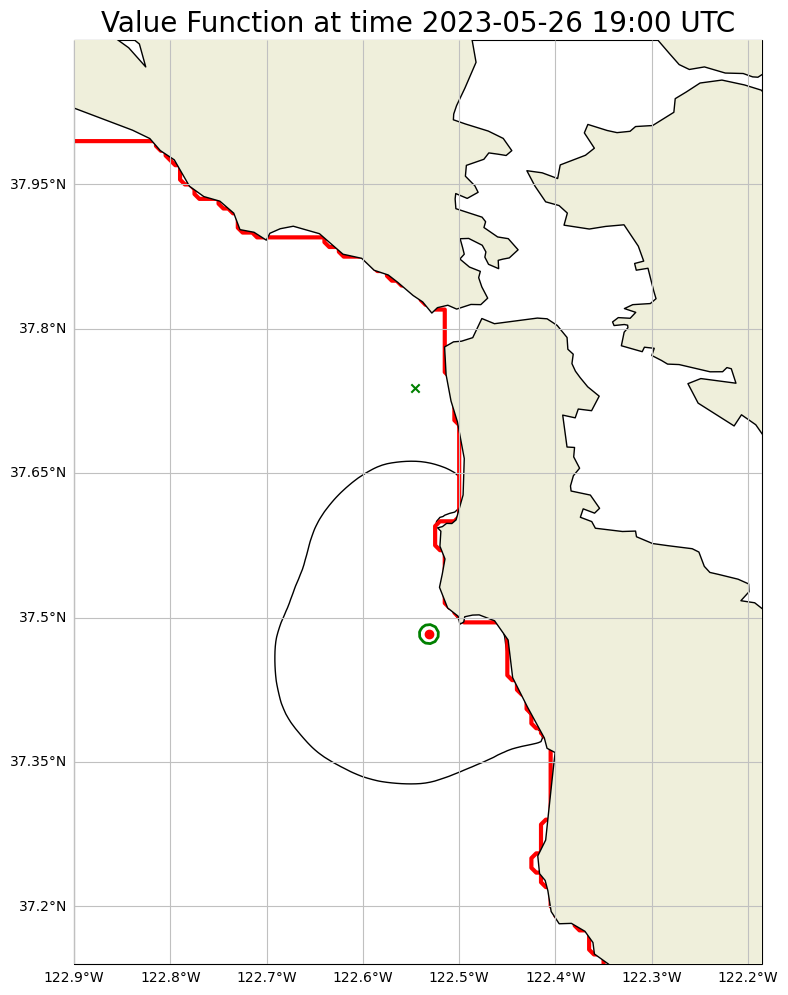

In [23]:
# Note: this answers the question: starting at problem.start_state, how far can I get in Y hours?
hours_ahead = 24
print("Starting at {} \n how far can I get in {} hours?".format(constructor.problem.start_state, hours_ahead))

fwd_controller.plot_reachability_snapshot(
    rel_time_in_seconds=hours_ahead*3600
)

# Experiment with Closed-Loop Control

In [17]:
print("current UTC datetime is: ", datetime.datetime.now())

# set Start point and time
start_time = "2023-05-25T19:00:00+00:00"  # in UTC
HMB_point = {"lat": 37.482812, "lon": -122.531450}

x_0_dict = {"date_time": start_time}
x_0_dict.update(HMB_point)

# set the center point of the target region (0.02 degrees radius means ≈2km radius)
x_T = {'lat': 37.3, 'lon': -122.5}

updated_missionConfig = {
    "target_radius": 0.02,  # in degrees
    "x_0": [x_0_dict],  # the start position and time
    "x_T": x_T,  # the target position
}

current UTC datetime is:  2023-05-25 14:57:20.389766


In [18]:
ctrl_config={  'T_goal_in_seconds': t_max_planning_ahead_in_seconds,
              'accuracy': 'high',
              'artificial_dissipation_scheme': 'local_local',
              'ctrl_name': 'ocean_navigation_simulator.controllers.hj_planners.HJReach2DPlanner.HJReach2DPlanner',
              'deg_around_xt_xT_box': 0.3,
              'direction': 'multi-time-reach-back',
              'grid_res': 0.005,
              'n_time_vector': 100,
              'obstacle_dict': {'obstacle_value': 1,
                                'obstacle_file': 'bathymetry_distance_res_0.004_max_elevation_0_northern_california.nc',
                                'safe_distance_to_obstacle': 0},
              'progress_bar': True,
              'replan_every_X_seconds': None,
              'replan_on_new_fmrc': False,
              'calc_opt_traj_after_planning': True,
              'use_geographic_coordinate_system': True}

In [19]:
# Step 0: Create Constructor object which contains arena, problem, controller
constructor = Constructor(
    arena_conf=arena_config,
    mission_conf=updated_missionConfig,
    objective_conf=objectiveConfig,
    ctrl_conf=ctrl_config,
    observer_conf={"observer": None},
    timeout_in_sec=simulation_timeout,
    throw_exceptions=False,
)

# Step 1.1 Retrieve problem
problem = constructor.problem

# Step 1.2: Retrieve arena
arena = constructor.arena
observation = arena.reset(platform_state=problem.start_state)
problem_status = arena.problem_status(problem=problem)

# Step 2: Retrieve Controller
controller = constructor.controller

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.


In [20]:
#% Run first planning
action = controller.get_action(observation=observation)

The requested final time is not part of the subset (requested: [2023-05-25 19:00:00+00:00, 2023-05-28 07:00:00+00:00]). (files: x_range: [-145.38, -112.1], y_range: [18.42, 55.78], t_range:['2023-05-25 06-00-00', '2023-05-28 03-00-00'])
Loaded forecast data does not contain the full time-horizon from x_t 2023-05-25 19:00:00+00:00 to T_goal_in_seconds 216000. Automatically adjusting to maximum available time in this forecast.
100%|##########################################################################################################################################|  1.0000/1.0 [00:05<00:00,  5.27s/sim_s]


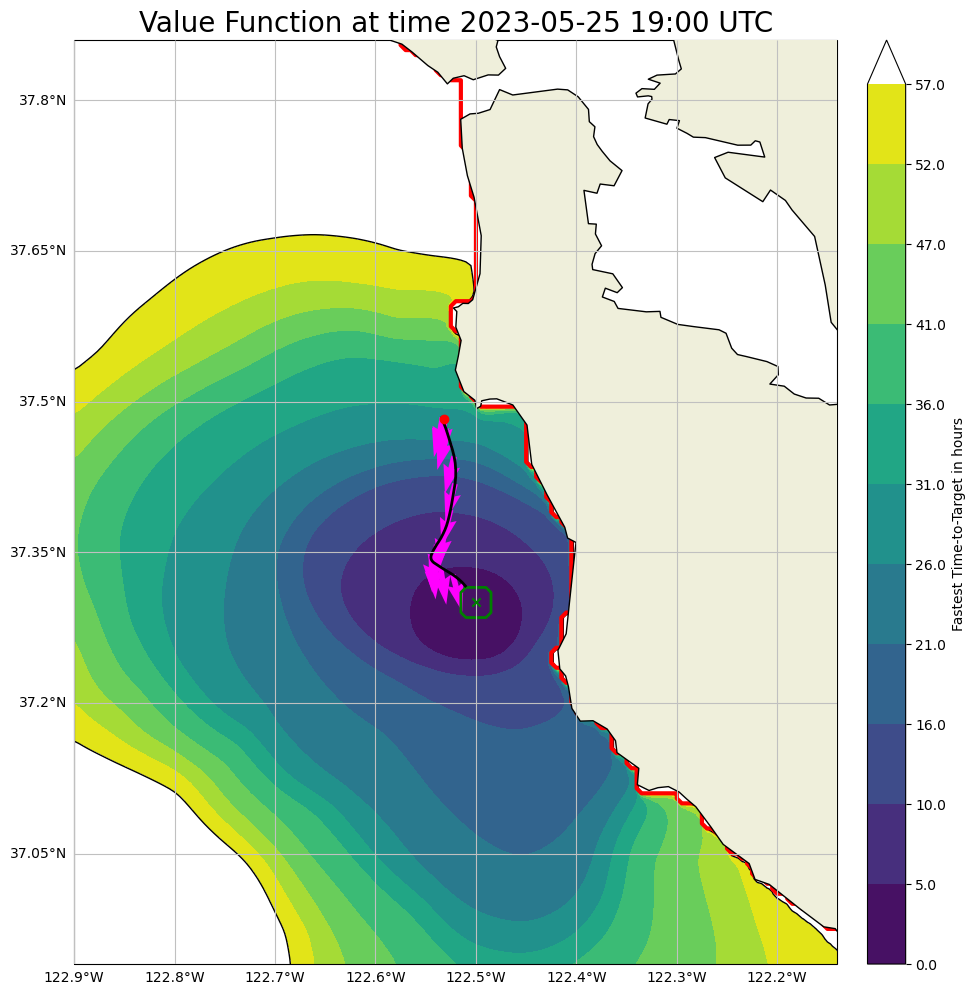

In [21]:
 # Visualize plan if forecast is accurate
ax = controller.plot_reachability_snapshot(
    rel_time_in_seconds=0,
    granularity_in_h=5,
    alpha_color=1,
    time_to_reach=True,
    fig_size_inches=(12, 12),
    plot_in_h=True,
    return_ax=True,
)

# problem.plot(ax=ax)
ax.plot(controller.x_traj[0, :], controller.x_traj[1, :], color='k', label="State Trajectory", linewidth=2)
ctrl_stride = 4
## For non-affine system dynamics
# u_vec = controller.contr_seq[0, ::ctrl_stride] * np.cos(controller.contr_seq[1, ::ctrl_stride])
# v_vec = controller.contr_seq[0, ::ctrl_stride] * np.sin(controller.contr_seq[1, ::ctrl_stride])
## For affine system dynamics
u_vec = controller.contr_seq[0, ::ctrl_stride]
v_vec = controller.contr_seq[1, ::ctrl_stride]
ax.quiver(
    controller.x_traj[0, :-1:ctrl_stride],
    controller.x_traj[1, :-1:ctrl_stride],
    u_vec,
    v_vec,
    color='magenta',
    scale=4,
    angles="xy",
    label="Control Inputs",
)
plt.show()

In [22]:
# Further animations of the value function
# controller.animate_value_func_3D()
# controller.plot_reachability_snapshot_over_currents(rel_time_in_seconds=0, granularity_in_h=5, time_to_reach=False)
# controller.plot_reachability_animation(time_to_reach=False, granularity_in_h=5, filename="test_reach_animation.mp4")
# controller.plot_reachability_animation(time_to_reach=True, granularity_in_h=5, with_opt_ctrl=True,
#                                     filename="test_reach_animation_w_ctrl.mp4", forward_time=True)

# Run Closed-loop simulation with TRUE currents

In [23]:
#% Run closed-loop simulation
while problem_status == 0:
    # Get action
    action = controller.get_action(observation=observation)

    # execute action
    observation = arena.step(action)

    # update problem status
    problem_status = arena.problem_status(problem=problem)

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checki

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checki

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checki

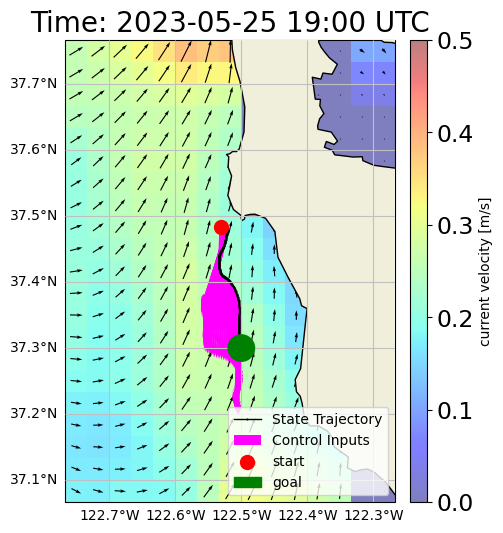

In [24]:
# Visualize the closed-loop trajectory
arena.plot_all_on_map(problem=problem, margin=0.1, vmax=0.5, vmin=0,
                      control_stride=4, control_vec_scale=4,
                      spatial_resolution=1 / 30)

In [32]:
# Animate closed-loop trajectory
abs_path = "/Volumes/Data/2_Work/2_Graduate_Research/1_Seaweed/OceanPlatformControl/generated_media/"
filename = "closed_loop_traj.mp4"

arena.animate_trajectory(margin=0.1,
                         ctrl_scale=8,
                         temporal_resolution=3600,
                         spatial_resolution=1 / 30,
                         vmax=0.5, vmin=0,
                         output=abs_path + filename)

took_h = (arena.state_trajectory[-1, 2] - arena.state_trajectory[0, 2]) / 3600
print("Closed-Loop Operation took {} hours".format(took_h))

Closed-Loop Operation took 41.666666666666664 hours


### For accessing the control & state trajectory

In [29]:
# # control trajectory where [power level between 0-1, angle in radians] for each time-step
arena.action_trajectory

In [32]:
# state trajectory where [lon, lat, posix-time, battery_charge in % (0-100), seaweed mass in kg, inside_garbage]
arena.state_trajectory[:,:3]

# Run just drifting simulation (using True currents, right now Copernicus)

In [10]:
passive_controller={
              'ctrl_name': 'ocean_navigation_simulator.controllers.PassiveFloatingController.PassiveFloatingController',
              }

In [11]:
# Step 0: Create Constructor object which contains arena, problem, controller
constructor = Constructor(
    arena_conf=arena_config,
    mission_conf=updated_missionConfig,
    objective_conf=objectiveConfig,
    ctrl_conf=passive_controller,
    observer_conf={"observer": None},
    timeout_in_sec=simulation_timeout,
    throw_exceptions=True,
)

# Step 1.1 Retrieve problem
problem = constructor.problem

# Step 1.2: Retrieve arena
arena = constructor.arena
observation = arena.reset(platform_state=problem.start_state)
problem_status = arena.problem_status(problem=problem)

# Step 2: Retrieve Controller
controller = constructor.controller

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.


In [12]:
#% Run closed-loop simulation
while problem_status == 0:
    # Get action
    action = controller.get_action(observation=observation)

    # execute action
    observation = arena.step(action)

    # update problem status
    problem_status = arena.problem_status(problem=problem)
print("Problem Status: ", arena.problem_status_text(problem_status))

Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checking if inside.
Arena: Hindcast Ocean Source does not have x, y grid. Not checki

Problem Status:  Stranded


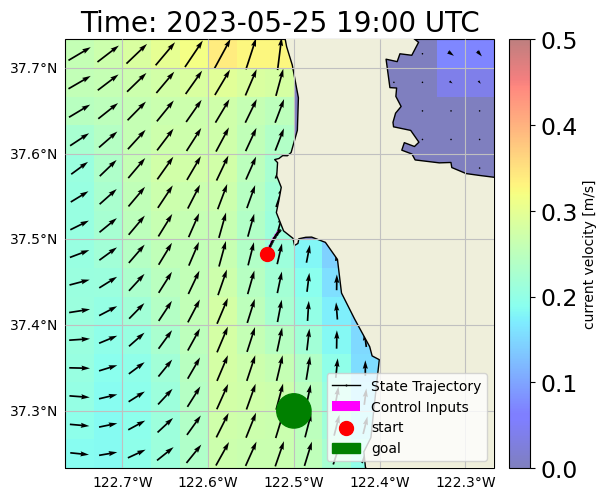

In [15]:
# Visualize the closed-loop trajectory
arena.plot_all_on_map(problem=problem, margin=0.1, vmax=0.5, vmin=0,
                      control_stride=4, control_vec_scale=4,
                      spatial_resolution=1 / 30)